# DY TMD analysis 

In [1]:
import os,sys
import threading
import copy
import numpy as np
import pandas as pd
from mpmath import fp

from scipy.integrate import quad,fixed_quad
from scipy.special import jv, zeta
from scipy import interpolate
from scipy.optimize import leastsq,least_squares

import types
from timeit import time

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab as py
import matplotlib.gridspec as gridspec

import lhapdf

#--jupyter widgets
from IPython.display import display,clear_output
import ipywidgets as widgets



<ipython-input-1-f47de02ca85b>:18: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8m4dt2m3 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
fitpack_path = '/work/JAM/barryp/JAM/fitpack2/'
#os.environ['FITPACK'] = fitpack_path
sys.path.insert(0, fitpack_path)

In [3]:
#ls /work/JAM/barryp/JAM/fitpack2/qcdlib

In [4]:
from tools.tools import load, save, checkdir,lprint
from tools.config import conf, load_config
from qcdlib.aux import AUX
from qcdlib.eweak import EWEAK
from qcdlib.alphaS import ALPHAS
from fitlib.resman import RESMAN
from fitlib.parman import PARMAN
from fitlib.maxlike import MAXLIKE
from analysis.corelib import core

In [5]:
os.environ['FITPACK']='/work/JAM/barryp/JAM/fitpack2/'
os.environ['LHAPDF_DATA_PATH']='/work/JAM/apps/lhapdf_tables/'
os.environ['LHAPDF_DATA_PATH']='/work/JAM/barryp/misc/:'+os.environ['LHAPDF_DATA_PATH']
os.environ['LHAPDF_DATA_PATH']='/work/JAM/apps/lhapdf_tables/more/more1:'+os.environ['LHAPDF_DATA_PATH']
os.environ["PATH"]='/work/JAM/apps/bin:'+os.environ["PATH"]

## load realistic JAM pdfs

In [6]:
#--pion PDFs
path='/w/jam-sciwork18/barryp/JAM/analysis-LCS/NLOpy3/'

msrs = core.get_replicas(path)

In [7]:
irep=0
istep=max(msrs[0]['order'].keys())

In [8]:
load_config('%s/input.py'%path)
conf['datasets']={}
resman=RESMAN(parallel=False,datasets=False)
resman.parman.order=copy.copy(msrs[irep]['order'][istep])
resman.parman.set_new_params(msrs[irep]['params'][istep],initial=True)
conf['params'].keys()

dict_keys(['pdf', 'ppdf', 'ffpion', 'ffkaon', 'pdf-pion', 'p->pi,n'])

### to avoid changing pdf-pion we do  

In [9]:
for _  in conf['params']:
    for __ in conf['params'][_]:
        #print(_,__,conf['params'][_][__])
        conf['params'][_][__]['fixed']=True

In [10]:
resman=RESMAN(parallel=False,datasets=False)
resman.parman.order

[]

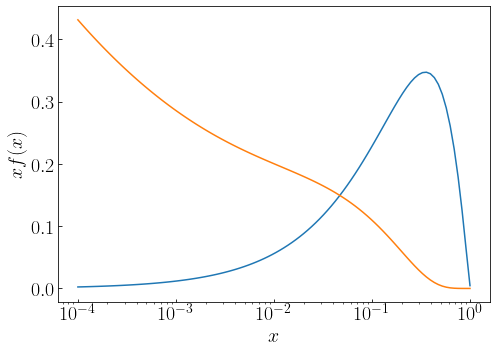

In [11]:
def test():
    pdfpion=conf['pdf-pion']
    
    nrows,ncols=1,1
    fig = py.figure(figsize=(ncols*7,nrows*5))
    ax=py.subplot(nrows,ncols,1)

    x=10**np.linspace(-4,np.log10(0.99),100)
    Q2=10.0
    xubv=[pdfpion.get_xF(_,Q2,'ub')-pdfpion.get_xF(_,Q2,'u') for _ in x]
    xu=[pdfpion.get_xF(_,Q2,'u') for _ in x]
    ax.plot(x,xubv)
    ax.plot(x,xu)
    
    ax.semilogx()
    ax.set_xlabel(r'$x$',size=20)
    ax.set_ylabel(r'$xf(x)$',size=20)
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    #ax.text(0.6,0.2,r'$\mu_Q =Q=10 {\rm GeV}$',transform=ax.transAxes,size=20)
    py.tight_layout()

test()

In [12]:
class TMD_MODEL:
    """
    This class provides specific realization for nonperturbative behavior of TMDs
    """
    
    def __init__(self):
        self.aux=conf['aux']
        #- set constants
        self.Q0 = 1.3
        self.C1 = 2 * np.exp(-self.aux.euler)
        self.bmax=self.C1/self.Q0 #--so that mub > mu_0
        self.C2=1.0
        
        self.get_bstar=lambda bT: bT/np.sqrt(1+bT**2/self.bmax**2)
        self.get_mub=lambda bT: self.C1/self.get_bstar(bT)
    

### perturbative part of the evolution  (perturbative Sudakov and Collisn-Soper kernel)

In [13]:
class TMD_EVOLUTION_PERT:
    """
    This class sets up the perturbative Sudakov form factor
    we always need exp[S_pert] and it is calculated in perturbative regime
    """
    
    def __init__(self,order = 'NLL'):
        """
        order=LL, NLL, etc
        """
        if 'TMDorder' in conf: self.order=conf['TMDorder'][1] #--get resummation order
        else : self.order=order
            
        if self.order=='LL':     self.iorder=0
        elif self.order=='NLL':  self.iorder=1
        elif self.order=='N2LL': self.iorder=2
        elif self.order=='N3LL': self.iorder=3
            
        self.setup()
        
    def setup(self):
        aux = conf['aux']
        self.alphaS=conf['alphaS']
  
        #--setup the evolution
        #self.euler=conf['aux'].euler
        #self.C1=conf['aux'].C1
        #self.bTmax=conf['aux'].bmax
        self.euler=conf['aux'].euler
        self.C1=conf['tmd_model'].C1
        self.C2=conf['tmd_model'].C2
        self.bmax=conf['tmd_model'].bmax
  
        # we will store all values of evolution
        self.storage={}
    
    #- Typical log in the expansion
    def get_Log(self,bT,mu):  
        return np.log(mu*bT/self.C1)
  
    #- Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
    def get_Ktilde(self,bT,mu):
        
        aS=self.alphaS.get_alphaS(mu**2)/(4*np.pi) #- alphaS/(4 pi)
        log=self.get_Log(bT,mu) #- Typical logarithm
        Nf=conf['alphaS'].get_Nf(mu**2) #- Number of flavors
        CF = conf['aux'].CF
        CA = conf['aux'].CA
        TR = conf['aux'].TR 
        zeta2 = zeta(2)
        zeta3 = zeta(3)
        zeta4 = zeta(4)
        zeta5 = zeta(5)
        pi = np.pi
        
        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-pi**2/3)*CA - (20/9)*TR*Nf
        Gamma3 = CA**2*(245/6 - 134*pi**2/27 + 11*pi**4/45 + 22*zeta3/3) \
                    + CA*TR*Nf*(-418/27 + 40*pi**2/27 - 56*zeta3/3) \
                    + CF*TR*Nf*(-55/3 + 16*zeta3) - (16/27)*TR**2*Nf**2
        beta1 = (11/3)*CA - (4/3)*TR*Nf
        beta2 = 34*CA**2/3 - 20*CA*TR*Nf/3 - 4*CF*TR*Nf
        
        d20 = CA*(404/27 - 14*zeta3) - 112*TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-CA**2/2)*(-176*zeta3*zeta2/3 + 6392*zeta2/81 + 12328*zeta3/27 + 154*zeta4/3 - 192*zeta5 - 297029/729) \
                - CA*TR*Nf*(-824*zeta2/81 - 904*zeta3/27 + 20*zeta4/3 + 62626/729) \
                - 2*TR**2*Nf**2*(-32*zeta3/9 - 1856/729) \
                - CF*TR*Nf*(-304*zeta3/9 - 16*zeta4 + 1711/27)
        ######################################

        Ktilde = 0
    
        if self.iorder>0: 
            
            Ktilde += -8 * CF * aS * log
            
        if self.iorder>1:
            
            Ktilde += 8 * CF * aS**2 * (  \
                    +  (2./3. * Nf - 11./3. * CA) * log**2 \
                    +  (-67./9. * CA + pi**2/3. * CA + 10./9. * Nf) * log \
                    +  (7./2. * zeta3 - 101./27.) * CA + 14./27. * Nf )
            
        if self.iorder>2:
            
            Ktilde += -2*CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869
            
        return Ktilde
    
        
    #- Anomalous dimension of TMD operator expanded in alphaS, Eq. (58) of PhysRevD.96.054011
    def get_gammaF(self,mu):
        
        aS=self.alphaS.get_alphaS(mu**2)/(4*np.pi) #- alphaS/(4 pi)
        Nf=conf['alphaS'].get_Nf(mu**2) #- Number of flavors
        CF = conf['aux'].CF
        CA = conf['aux'].CA
        TR = conf['aux'].TR 
        zeta2 = zeta(2)
        zeta3 = zeta(3)
        zeta4 = zeta(4)
        zeta5 = zeta(5)
        pi = np.pi
        
        gammaF = 0
        
        if self.iorder>0:
            
            gammaF += 6. * CF * aS
            
        if self.iorder>1:
            
            gammaF += aS**2 * ( CF**2 * (3. - 4. * pi**2 + 48. * zeta3)\
                    + CF * CA * (961./27. + 11. * pi**2/3. - 52. * zeta3)\
                    + CF * Nf * (-130./27. - 2. * pi**2/3.) )
            
        if self.iorder>2:
            
            gammaF += aS**3 * ( CF**2 * Nf * (-2953./27. + 26. * pi**2/9 + 28. * pi**4/27 - 512. * zeta3/9.)\
                    + CF * Nf**2 * (-4834./729. + 20. * pi**2/27. + 16. * zeta3/27. )\
                    + CF**3 * (29. + 6. * pi**2 + 16. * pi**4/5. + 136. * zeta3 - 32. * pi**2 * zeta3/3. - 480. * zeta5)\
                    + CA**2 * CF * (139345./1458. + 7163. * pi**2/243. + 83. * pi**4/45. - 7052. * zeta3/9. + 88. * pi**2 * zeta3/9. + 272. * zeta5 )\
                    + CA * CF * Nf * (17318./729. - 2594. * pi**2/243. - 22. * pi**4/45. + 1928. * zeta3/27.)\
                    + CA * CF**2 * (151./2. - 410. * pi**2/9. - 494. * pi**4/135. + 1688. * zeta3/3. + 16. * pi**2 * zeta3/3. + 240. * zeta5) )
        
        return gammaF
        
    #- Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
    def get_gammaK(self,mu):
        
        aS=self.alphaS.get_alphaS(mu**2)/(4*np.pi) #- alphaS/(4 pi)
        Nf=conf['alphaS'].get_Nf(mu**2) #- Number of flavors
        CF = conf['aux'].CF
        CA = conf['aux'].CA
        TR = conf['aux'].TR 
        zeta2 = zeta(2)
        zeta3 = zeta(3)
        zeta4 = zeta(4)
        zeta5 = zeta(5)
        pi = np.pi
        
        gammaK = 8. * CF * aS
        
        if self.iorder>0:
            
            gammaK += aS**2 * ( CA * CF * (536./9. - 8. * pi**2/3.)\
                    - 80./9. * CF * Nf )
            
        if self.iorder>1:
            
            gammaK += aS**3 * ( -32./27. * CF * Nf**2\
                + CA * CF * Nf * (-1672./27. + 160. * pi**2/27. - 224. * zeta3/3.)\
                + CA**2 * CF  * (980./3. - 1072. * pi**2/27. + 88. * pi**4/45. + 176. * zeta3/3.)\
                + CF**2 * Nf * (-220./3. + 64. * zeta3) )
            
        if self.iorder>2:
            
            gammaK += aS**4 * 2*(20702 - 5171.9*Nf + 195.5772*Nf**2 + 3.272344*Nf**3) 
                    # see 1707.08315: A4  = Gamm_cusp and gamma_K = 2*Gamma_cusp
                    # A4 = 20702(2) − 5171.9(2) nf + 195.5772 nf^2 + 3.272344 nf^3

        return gammaK
    
    #- perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_Evolution_exponent_perturbative(self,muQ,zeta,bT):
        
        mub=conf['tmd_model'].get_mub(bT)
        bstar=conf['tmd_model'].get_bstar(bT)

       
        key=(muQ,zeta,bstar)
        if key not in self.storage:
            self.storage[key]=np.log(np.sqrt(zeta)/mub)*self.get_Ktilde(bstar,mub) + quad(lambda mup: 1/mup*(self.get_gammaF(mup)-np.log(np.sqrt(zeta)/mup)*self.get_gammaK(mup)),mub,muQ)[0]

        return self.storage[key]

    #- Exponential of perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_exp_Evolution_exponent_perturbative(self,muQ,zeta,bT):
        
        return np.exp(self.get_Evolution_exponent_perturbative(muQ,zeta,bT)) 


           

### Nonperturbative evolution univeral part of Collins-Soper kernel at large bT

In [14]:
class TMD_EVOLUTION_UNIVERSAL_NONPERT:
    
    def __init__(self):
        conf['tmd_model'].g2=0.2  

    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_gK(self,bT):
        g2=conf['tmd_model'].g2
        return bT * conf['tmd_model'].get_bstar(bT) * g2/2. 

    #- Exponential Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_exp_Evolution_universal_nonperturbative(self,zeta,bT):
        return np.exp( - self.get_gK(bT) * np.log(np.sqrt(zeta)/conf['tmd_model'].Q0) )



### Nonperturbative evolution intrinsic part for TMDPF

In [15]:
class TMD_EVOLUTION_INTRINSIC_NONPERT:
    
    def __init__(self):
        self.g1= 3.77759629e-01
        self.g3=-1.11608373e-01
        self.g4=1.65145977e-07

    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_gJ(self,x,bT):
        g1=self.g1
        g3=self.g3
        g4=self.g4
        return (g1 + g3 * x) * bT**2/np.sqrt(1 + np.abs(g4) * x**2 * bT**2)
  
    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_exp_Evolution_intrinsic_nonperturbative(self,x,Q,bT):
        return np.exp(-self.get_gJ(x,bT))


### hack parman to be tmd parmeters aware

In [16]:
# less /work/JAM/barryp/JAM/fitpack2/fitlib/parman.py

In [17]:
class DEV_PARMAN(PARMAN):
    
    def propagate_params(self,semaphore):
#         print(semaphore)
        flag=False

        if 'QCD'       in semaphore and semaphore['QCD']      ==1: self.set_QCD_params()
        if 'eweak'     in semaphore and semaphore['eweak']    ==1: self.set_eweak_params()

        dists = []
        #--leading power collinear distributions
        dists.extend(['pdf','ppdf','ffpion','ffkaon','ffhadron'])
        #--pion pdfs
        dists.extend(['pdf-pion','pdf-pion-int'])
        #--special pdfs for lattice observables
        dists.extend(['pdf(qpdf)'])
        #--dis related objects
        dists.extend(['t3ppdf','ht4','pol ht4','off','pol off'])
        #--transverse momentum dependent distributions
        #dists.extend(['tmd','tmd-pion'])

        for dist in dists:
            if dist in semaphore and semaphore[dist]==1: self.set_dist_params(dist)

        #--spitting functions
        if 'p->pi,n'   in semaphore and semaphore['p->pi,n']  ==1: self.set_p_to_pi_n_params()

        #--finite volume effects
        if 'FV'        in semaphore and semaphore['FV']       ==1: self.set_FV_params()
        
        #--TMD parameter propagation
        if 'universal' in semaphore and semaphore['universal']==1: self.set_universal_params()
        if 'tmd'       in semaphore and semaphore['tmd']      ==1: self.set_tmd_params()
        if 'tmd-pion'  in semaphore and semaphore['tmd-pion'] ==1: self.set_tmdpion_params()
        

    def set_universal_params(self):
        conf['tmd_model'].g2=conf['params']['universal']['g2']['value']
        
    def set_tmd_params(self):
        conf['tmd_pdf_model'].g1=conf['params']['tmd']['g1']['value']
        conf['tmd_pdf_model'].g3=conf['params']['tmd']['g3']['value']
        conf['tmd_pdf_model'].g4=conf['params']['tmd']['g4']['value']
        
    def set_tmdpion_params(self):
        conf['tmd_pdf-pion_model'].g1=conf['params']['tmd-pion']['g1']['value']
        conf['tmd_pdf-pion_model'].g3=conf['params']['tmd-pion']['g3']['value']
        conf['tmd_pdf-pion_model'].g4=conf['params']['tmd-pion']['g4']['value']

        
    def gen_report(self):
        data={_:[] for _ in ['idx','dist','type','value']}
        cnt=0
        for k in conf['params']:
            for kk in sorted(conf['params'][k]):
                if  conf['params'][k][kk]['fixed']==False:
                    cnt+=1
                    data['idx'].append('%d'%cnt)
                    data['dist'].append('%10s'%k)
                    data['type'].append('%10s'%kk)
                    data['value'].append('%10.2e'%conf['params'][k][kk]['value'])
                    
        data=pd.DataFrame(data)
        msg=data.to_html(col_space=80,index=False,justify='left')
        return msg

In [18]:
conf['params']['universal']={}
conf['params']['universal']['g2']={'value': 0.1,            'min':-1, 'max': 1, 'fixed': False}

conf['params']['tmd']={}
conf['params']['tmd']['g1']      ={'value': 3.77759629e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g3']      ={'value':-1.11608373e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g4']      ={'value': 1.65145977e-07, 'min':-1, 'max': 1, 'fixed': False}

conf['params']['tmd-pion']={}
conf['params']['tmd-pion']['g1'] ={'value': 3.77759629e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd-pion']['g3'] ={'value':-1.11608373e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd-pion']['g4'] ={'value': 1.65145977e-07, 'min':-1, 'max': 1, 'fixed': False}

In [19]:
conf['tmd_model']          = TMD_MODEL() # all constants and functions will be here
conf['tmd_pdf_model']      = TMD_EVOLUTION_INTRINSIC_NONPERT() #--initialize the proton TMD
conf['tmd_pdf-pion_model'] = TMD_EVOLUTION_INTRINSIC_NONPERT() #--initialize the pion TMD
parman=DEV_PARMAN()
print(parman.par)
print(parman.order)

[ 1.00000000e-01  3.77759629e-01 -1.11608373e-01  1.65145977e-07
  3.77759629e-01 -1.11608373e-01  1.65145977e-07]
[[1, 'universal', 'g2'], [1, 'tmd', 'g1'], [1, 'tmd', 'g3'], [1, 'tmd', 'g4'], [1, 'tmd-pion', 'g1'], [1, 'tmd-pion', 'g3'], [1, 'tmd-pion', 'g4']]


### Test

In [20]:
conf['tmd_model'] = TMD_MODEL() # all constants and functions will be here
conf['TMDorder']  = ('NLO','NLL') #--introduce tuple for (order,resummation order)
pert              = TMD_EVOLUTION_PERT()
nonpert_univ      = TMD_EVOLUTION_UNIVERSAL_NONPERT()
nonpert_intrin    = TMD_EVOLUTION_INTRINSIC_NONPERT()

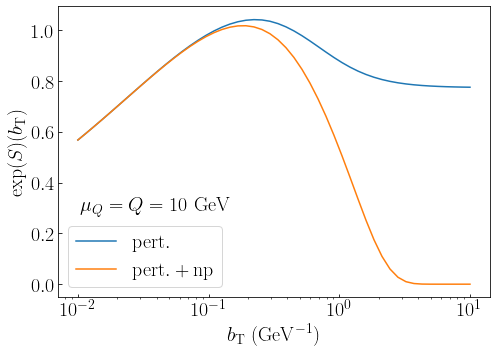

In [21]:
def test():
    nrows,ncols=1,1
    fig = py.figure(figsize=(ncols*7,nrows*5))
    ax=py.subplot(nrows,ncols,1)

    bT=10**np.linspace(-2,1,50)
    x = 0.1
    Q = 10
    zeta = Q**2
    muQ=conf['tmd_model'].C2*Q
    expS1=[pert.get_exp_Evolution_exponent_perturbative(muQ,zeta,_) for _ in bT]
    
    expS2=[   pert.get_exp_Evolution_exponent_perturbative(muQ,zeta,_)\
           * nonpert_univ.get_exp_Evolution_universal_nonperturbative(zeta,_)\
           * nonpert_intrin.get_exp_Evolution_intrinsic_nonperturbative(x,Q,_)  for _ in bT]
    
    ax.plot(bT,expS1,label=r'$\rm pert.$')
    ax.plot(bT,expS2,label=r'$\rm pert.+np$')
    ax.legend(loc=3,fontsize=20)
    ax.semilogx()
    ax.set_xlabel(r'$b_{\rm T} \; ({\rm GeV}^{-1})$',size=20)
    ax.set_ylabel(r'$\exp(S)(b_{\rm T})$',size=20)
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.text(0.05,0.3,r'$\mu_Q =Q=10~{\rm GeV}$',transform=ax.transAxes,size=20)
    py.tight_layout()

test()

### Let us construct now TMD PDF, the OPE part valid at small bT

In [22]:
class TMD_OPE_LHAPDF:
    
    def __init__(self,setname,iset=0):
        self.order=conf['TMDorder'][0] #--get fixed order
        if self.order=='LO': 
            self.iorder=0
        elif self.order=='NLO':
            self.iorder=1
            
        self.pdf=lhapdf.mkPDF(setname,iset)
        self.iflav=[5,4,3,2,1,-1,-2,-3,-4,-5]
        self.C1=conf['tmd_model'].C1
    
    #- Typical log in the expansion
    def get_Log(self,bT,mu):  
        return np.log(mu*bT/self.C1)
    
    def _get_NLOq_integrand(self,xh,mu,x,bT,flav,zeta):
        alphaS=conf['alphaS'].get_alphaS(mu**2)
        Log=self.get_Log(bT,mu)
        PDF=self.pdf.xfxQ2(flav,x/xh,mu**2)/(x/xh)
        term1=-2*Log*(2.0/(1-xh)*(PDF/xh-self.pdf.xfxQ2(flav,x,mu**2)/x)-PDF/xh*(1+xh))
        term2=PDF/xh*(1-xh)
        term3=1.0/(1-x)*(self.pdf.xfxQ2(flav,x,mu**2)/x*(-2*Log**2-2*Log*np.log(zeta/mu**2)))
        return term1+term2+term3
    
    def _get_NLOg_integrand(self,xh,mu,x,bT):
        alphaS=conf['alphaS'].get_alphaS(mu**2)
        PDF=self.pdf.xfxQ2(21,x/xh,mu**2)/(x/xh)
        return PDF/xh*(-self.get_Log(bT,mu)*(1-2*xh*(1-xh))+xh*(1-xh))
    
    def get_OPE(self,x,bT,zeta):
        # For LL and NLL it is relatively easy, NNLL will require some work    
        mub=conf['tmd_model'].get_mub(bT)
        
        CF=conf['aux'].CF
        TF=conf['aux'].TF
        
        data={_: self.pdf.xfxQ2(_,x,mub**2)/x for _ in self.iflav} # Notice that a dictionary is returned, [flavor: pdf(x)]
        
        if self.iorder>0:
            
            alphaS=conf['alphaS'].get_alphaS(mub**2)
            
            for k in self.iflav:
                
                NLOq=alphaS*CF/2.0/np.pi*fixed_quad(np.vectorize(lambda xh: self._get_NLOq_integrand(xh,mub,x,bT,k,zeta)), x, 1, n=100)[0]
                NLOg=alphaS*TF/np.pi*fixed_quad(np.vectorize(lambda xh: self._get_NLOg_integrand(xh,mub,x,bT)), x, 1, n=100)[0]
                data[k] += NLOq + NLOg

        return data


class TMD_OPE:
    
    def __init__(self,mellin=None,collinear='pdf-pion'):
        self.order=conf['TMDorder'][0] #--get fixed order
        
        if self.order=='LO': 
            self.iorder=0
        elif self.order=='NLO':
            self.iorder=1
        
        self.fmap={5:'b',4:'c',3:'s',2:'u',1:'d',-1:'db',-2:'ub',-3:'sb',-4:'cb',-5:'bb'}#,21:'g'}
        if mellin==None: self.mellin=conf['mellin']
        else: self.mellin=mellin
        self.pdf=conf[collinear]
        self.euler=conf['aux'].euler
        self.C1=conf['tmd_model'].C1
        self.storage={}
    
    #- Typical log in the expansion
    def get_Log(self,bT,mu):  
        return np.log(mu*bT/self.C1)
    
    def get_CqN(self,bT,zeta):
        
        N=self.mellin.N
        CF=conf['aux'].CF
        
        mub=conf['tmd_model'].get_mub(bT)
        alphaS=conf['alphaS'].get_alphaS(mub**2)
        Log=self.get_Log(bT,mub)
        LO=np.ones(len(N))
        mell1=np.array([1.0/n+1.0/(n+1)+2*self.euler for n in N]) + 2*conf['aux'].get_psi(0,N)
        mell2=np.array([1.0/n-1.0/(n+1) for n in N])
        NLO=alphaS*CF/2.0/np.pi*(-2*Log**2-2*Log*np.log(zeta/mub**2)+2*Log*(mell1)+mell2)
        return LO+NLO
    
    def get_CgN(self,bT):
        
        N=self.mellin.N
        TF=conf['aux'].TF
        
        mub=conf['tmd_model'].get_mub(bT)
        alphaS=conf['alphaS'].get_alphaS(mub**2)
        Log=self.get_Log(bT,mub)
        mell1=np.array([1.0/n-2.0/(n+1)+2.0/(n+2) for n in N])
        mell2=np.array([1.0/(n+1)-1.0/(n+2) for n in N])
        return alphaS*TF/np.pi*(-Log*mell1+mell2)
    
    #- For LL and NLL it is relatively easy, NNLL will require some work    
    def get_OPE(self,x,bT,zeta):
        mub=conf['tmd_model'].get_mub(bT)
        if self.order == 'LO': 
            data={_:self.pdf.get_xF(x,mub**2,self.fmap[_])/x for _ in self.fmap}
        elif self.order == 'NLO':
            alphaS=conf['alphaS'].get_alphaS(mub**2)
            self.pdf.evolve(mub**2)
            lenN=len(self.mellin.N)
            data={_:0 for _ in self.fmap}
            qkey=(bT,zeta,'q')
            if qkey not in self.storage:
                self.storage[qkey]=self.get_CqN(bT,zeta)
            CqN=self.storage[qkey]
            gkey=(bT,'g')
            if gkey not in self.storage:
                self.storage[gkey]=self.get_CgN(bT)
            CgN=self.storage[gkey]
            for k in self.fmap:
                CFN=CqN*self.pdf.storage[mub**2][self.fmap[k]] + CgN*self.pdf.storage[mub**2]['g']
                data[k]=self.mellin.invert(x,CFN)
        return data

In [23]:
def test():
    tmp=TMD_OPE_LHAPDF('EPPS16nlo_CT14nlo_Pt195')
    print(tmp.get_OPE(0.1,0.1,10))
    tmp=TMD_OPE(mellin=conf['mellin-pion'])
    print(tmp.get_OPE(0.1,0.1,10))
test()

{5: 0.11621388881539389, 4: 0.3386432029479946, 3: 0.7180175987342083, 2: 5.235826765132612, 1: 5.782115948726463, -1: 1.1411831954740967, -2: 1.182714448290356, -3: 0.7180175987342083, -4: 0.3386432029479946, -5: 0.11621388881539389}
{5: 0.09827727608361841, 4: 0.22612832792979648, 3: 1.0650166440138522, 2: 1.064656618208299, 1: 3.5251599072809783, -1: 1.064656618208299, -2: 3.5251599072809783, -3: 1.0650166440138522, -4: 0.22612832792979648, -5: 0.09827727608361841}


Hard factor Drell-Yan

In [24]:
class HARD_FACTOR_DY:
    
    def __init__(self):

        if 'TMDorder' in conf: self.order=conf['TMDorder'][0] #--get fixed order
        else : self.order='NLO'
            
        if self.order=='LO':
            self.iorder=0
        elif self.order=='NLO':
            self.iorder=1
        elif self.order=='N2LO':
            self.iorder=2
       
        
    def get_Hard_factor(self,muQ,Q):
        #-- Hard facror Eq. (63) of PhysRevD.96.054011
        
        aS=conf['alphaS'].get_alphaS(muQ**2)/(4*np.pi) #- alphaS/(4 pi)
        Nf=conf['alphaS'].get_Nf(muQ**2) #- Number of flavors
        CF=conf['aux'].CF
        CA=conf['aux'].CA

        T=np.log(Q**2/muQ**2)
        
        Hard_factor=1
        
        if self.iorder>0:
            
            Hard_factor += CF * aS * (-16+ 7* np.pi**2/3 + 6* T - 2* T**2)
            
        if self.iorder>1:
            
            Hard_factor += aS**2 * (CF**2 * (511./4. - 83. * np.pi**2/3. + 67. * np.pi**4/30. - 60. * zeta(3)\
                        + T*( -93. + 10. * np.pi**2 + 48. * zeta(3)) + T**2 * (-14. * np.pi**2/3. + 50.) - 12. * T**3 + 2 * T**4)\
                        + CF * CA * (-51157./324. + 1061. * np.pi**2/54. - 8. * np.pi**4/45. + 626. * zeta(3)/9.\
                        + T*(2545./27 - 44.*np.pi**2/6. - 52. * zeta(3)) + T**2 * (2.*np.pi**2/3. - 233./9.) + 22./9. * T**3)\
                        + Nf * CF * (4085./162. - 91.*np.pi**2/27. + 4. * zeta(3)/9. + T*(8. * np.pi**2/9. - 418./27.)\
                        + 38./9. * T**2 - 4./9. * T**3) )
            
        return Hard_factor   

### Now we are ready to construct observables and W term

In [25]:
class WTERM:
    def __init__(self,mellin=conf['mellin-pion'],collinearA='pdf-pion',collinearB='EPPS16nlo_CT14nlo_W184',intrinsic_nonpertA=conf['tmd_pdf-pion_model'],intrinsic_nonpertB=conf['tmd_pdf_model']):
        
        self.collinearA=collinearA
        self.collinearB=collinearB
        self.tmdA=TMD_OPE(mellin=mellin,collinear=collinearA)
        self.tmdB=TMD_OPE_LHAPDF(collinearB)
        self.tmdAB_evolution_pert=TMD_EVOLUTION_PERT()
        self.tmdAB_evolution_nonpert=TMD_EVOLUTION_UNIVERSAL_NONPERT()
        #self.tmdA_evolution_nonpert=TMD_EVOLUTION_INTRINSIC_NONPERT()
        self.tmdA_evolution_nonpert=intrinsic_nonpertA
        #self.tmdB_evolution_nonpert=TMD_EVOLUTION_INTRINSIC_NONPERT()
        self.tmdB_evolution_nonpert=intrinsic_nonpertB
        self.Hard_factor=HARD_FACTOR_DY()
        self.Astorage={} #--Since A not fitted, calculate on first iteration and store
        self.Bstorage={} #--Since B not fitted, calculate on first iteration and store
        
    def Wtilde(self,bT,Q,s,y):
        tmdA=self.tmdA
        tmdB=self.tmdB
        muQ = conf['tmd_model'].C2*Q
        hard_factor = self.Hard_factor.get_Hard_factor(muQ,Q)
        xA = Q/s**0.5 * np.exp(y)
        xB = Q/s**0.5 * np.exp(-y)
        Nf=conf['alphaS'].get_Nf(Q**2)
        #- OPE part calculation
        zeta=Q**2
        keyOPE=(xA,xB,bT,Nf,zeta,self.collinearA)
        if keyOPE not in self.Astorage:
            tmdAflav = tmdA.get_OPE(xA, bT, zeta)
            tmdBflav = tmdB.get_OPE(xB, bT, zeta)
            # u = 2, ub =-2
            # d = 1, db =-1
            # s = 3, sb =-3
            OPE = (4.0/9.0)*tmdAflav[ 2]*tmdBflav[-2]\
             +(4.0/9.0)*tmdAflav[-2]*tmdBflav[ 2]\
             +(1.0/9.0)*tmdAflav[ 1]*tmdBflav[-1]\
             +(1.0/9.0)*tmdAflav[-1]*tmdBflav[ 1]\
             +(1.0/9.0)*tmdAflav[ 3]*tmdBflav[-3]\
             +(1.0/9.0)*tmdAflav[-3]*tmdBflav[ 3]
            if Nf>3: 
                OPE += (4.0/9.0)*(tmdAflav[ 4]*tmdBflav[-4]+tmdAflav[-4]*tmdBflav[ 4]) #--c,cb+cb,c
            if Nf>4: 
                OPE += (1.0/9.0)*(tmdAflav[ 5]*tmdBflav[-5]+tmdAflav[-5]*tmdBflav[ 5]) #--b,bb+bb,b
            self.Astorage[keyOPE]=OPE
        OPE=self.Astorage[keyOPE]
        #- Perturbative Sudakov calculation    
        keySUDAKOV = (zeta,bT)
        if keySUDAKOV not in self.Bstorage:
            SUDAKOV=pert.get_exp_Evolution_exponent_perturbative(muQ,zeta,bT)**2 #- **2 because we have this part from both A and B
            self.Bstorage[keySUDAKOV] = SUDAKOV
        SUDAKOV = self.Bstorage[keySUDAKOV]
        #- Non perturbative Sudakov and intrinsic calculation
        SUDAKOVNP =  self.tmdAB_evolution_nonpert.get_exp_Evolution_universal_nonperturbative(zeta,bT)**2 \
                   * self.tmdA_evolution_nonpert.get_exp_Evolution_intrinsic_nonperturbative(xA,Q,bT)\
                   * self.tmdB_evolution_nonpert.get_exp_Evolution_intrinsic_nonperturbative(xB,Q,bT) 
        return hard_factor * OPE * SUDAKOV * SUDAKOVNP
    
    def setup(self,Q,y,s):
        self.bT=10**np.linspace(-5,2,100)
        self.storage_Wtilde=np.array([self.Wtilde(_,Q,s,y) for _ in self.bT])
        
    def get_W(self,pT,Q,s,y,par=[[False],[False],[False]]):
        self.setup(Q,y,s)
        born=4*np.pi**2*conf['eweak'].get_alpha(Q**2)**2/9.0/Q**2/s
        Wtilde = interpolate.interp1d(self.bT,self.storage_Wtilde,fill_value=0,bounds_error=False) #--interpolated from self.bT
        W=1./2./np.pi*fixed_quad(np.vectorize(lambda bT: bT*jv(0,pT*bT)*Wtilde(bT)),1e-2,1e2,n=100)[0] #--integrate over interpolated function
        return born*W
    
    def get_Ed3sigdp3(self,pT,Qmin,Qmax,y,s):
        #--pp observable
        units=0.389379e9
        Qavg=(Qmin+Qmax)/2
#         xsec=fixed_quad(np.vectorize(lambda Q: 2*Q*1./np.pi*self.get_W(pT,Q,s,y)),Qmin,Qmax,n=10)[0] #--for integrating out Q
        xsec=1./np.pi*(Qmax**2-Qmin**2)*self.get_W(pT,(Qmin+Qmax)/2,s,y) #--trick to not do Q integration; probably won't use for final results
        return units*xsec
    
    def get_d2sigdxFdpT(self,pT,Qmin,Qmax,xF,s):
        #--pi-W observable
        units=0.389379e-27
        Qavg=(Qmin+Qmax)/2
        mT=np.sqrt(pT**2+Qavg**2)
        y=np.arcsinh(s**0.5*xF/(2*mT))
        self.setup(Qavg,y,s)
        jac=s**0.5/2/mT/np.cosh(y)*2*pT*(Qmax**2-Qmin**2)
        xsec=jac*self.get_W(pT,Qavg,s,y)
        return units*xsec
            

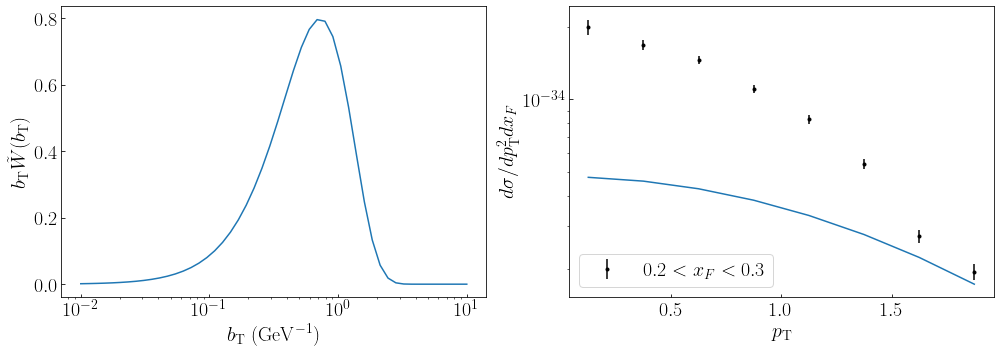

In [26]:
def test():
    tab=pd.read_excel('/work/JAM/barryp/JAM/fitpack2/database/pion_qT/expdata/1002.xlsx')
#     tab=pd.read_excel('/work/JAM/barryp/JAM/fitpack2/database/pion_qT/expdata/15372.xlsx')

    s=2*conf['aux'].M*tab.E.values
    tab['s']=pd.Series(s,index=tab.index)

    Qmin=tab.Qmin.values
    Qmax=tab.Qmax.values
    Qavg=0.5*(Qmin+Qmax)
    tab['Qmin']=pd.Series(Qmin,index=tab.index)
    tab['Qmax']=pd.Series(Qmax,index=tab.index)
    tab['Q']=pd.Series(Qavg,index=tab.index)

    pTmin,pTmax=tab.pTmin.values,tab.pTmax.values
    pT=0.5*(pTmin+pTmax)
    tab['pT']=pd.Series(pT,index=tab.index)  
    
    xFmin,xFmax=tab.xFmin.values,tab.xFmax.values
    xF=0.5*(xFmin+xFmax)
    tab['xF']=pd.Series(xF,index=tab.index)
    
    bT=10**np.linspace(-2,1,50)
    w=WTERM()
    Wtilde=np.array([w.Wtilde(_,5.5,s[0],0.21) for _ in bT])
    
    nrows,ncols=1,2
    fig = py.figure(figsize=(ncols*7,nrows*5))
    
    ax=py.subplot(nrows,ncols,1)
    ax.plot(bT,bT*Wtilde)
    ax.semilogx()
    ax.set_xlabel(r'$b_{\rm T} \; ({\rm GeV}^{-1})$',size=20)
    ax.set_ylabel(r'$b_{\rm T}\tilde{W}(b_{\rm T})$',size=20)
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    #ax.text(0.05,0.3,r'$\mu_Q =Q=10~{\rm GeV}$',transform=ax.transAxes,size=20)

    ax=py.subplot(nrows,ncols,2)
    d=tab.query('xFmin<0.25 and xFmax>0.25 and pT<2')
    thy=[w.get_d2sigdxFdpT(d['pT'].values[i],d['Qmin'].values[i],d['Qmax'].values[i],d['xF'].values[i],d['s'].values[i]) 
             for i in range(len(d['pT'].values))]
    ax.errorbar(d['pT'],d['value']/2/d['pT'],yerr=d['stat_u']/2/d['pT'],fmt='k.',label=r'$%.1f<x_F<%.1f$'%(d['xFmin'].values[0],d['xFmax'].values[0]))
#     ax.errorbar(d['pT'],d['value'],yerr=d['stat_u'],fmt='k.',label=r'$%.1f<x_F<%.1f$'%(d['xFmin'].values[0],d['xFmax'].values[0]))
    ax.plot(d['pT'],np.array(thy)/2/d['pT'])
    ax.semilogy()
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_xlabel(r'$p_{\rm T}$',size=20)
    ax.set_ylabel(r'$d\sigma/dp_{\rm T}^2dx_F$',size=20)
    ax.legend(loc=3,fontsize=20)
    
    py.tight_layout()
    
test()

### reader

In [27]:
tab=pd.read_excel('/work/JAM/barryp/JAM/fitpack2/database/pion_qT/expdata/1002.xlsx')
tab[:10]

,col,reaction,xFmin,xFmax,Qmin,Qmax,pTmin,pTmax,pT,obs,units,value,stat_u,%norm_c,E,target
0,E615,pi-p,0.0,0.1,4.05,8.55,0.00,0.25,0.125,d2sigma/dpTdx,cm^2/GeV,5.007000e-35,4.690000e-36,16.0,252.0,W
1,E615,pi-p,0.0,0.1,4.05,8.55,0.25,0.50,0.375,d2sigma/dpTdx,cm^2/GeV,1.180000e-34,7.500000e-36,16.0,252.0,W
2,E615,pi-p,0.0,0.1,4.05,8.55,0.50,0.75,0.625,d2sigma/dpTdx,cm^2/GeV,1.717000e-34,9.300000e-36,16.0,252.0,W
3,E615,pi-p,0.0,0.1,4.05,8.55,0.75,1.00,0.875,d2sigma/dpTdx,cm^2/GeV,1.892000e-34,1.050000e-35,16.0,252.0,W
4,E615,pi-p,0.0,0.1,4.05,8.55,1.00,1.25,1.125,d2sigma/dpTdx,cm^2/GeV,1.642000e-34,1.040000e-35,16.0,252.0,W
5,E615,pi-p,0.0,0.1,4.05,8.55,1.25,1.50,1.375,d2sigma/dpTdx,cm^2/GeV,1.657000e-34,1.140000e-35,16.0,252.0,W
6,E615,pi-p,0.0,0.1,4.05,8.55,1.50,1.75,1.625,d2sigma/dpTdx,cm^2/GeV,1.097000e-34,1.010000e-35,16.0,252.0,W
7,E615,pi-p,0.0,0.1,4.05,8.55,1.75,2.00,1.875,d2sigma/dpTdx,cm^2/GeV,6.992000e-35,9.260000e-36,16.0,252.0,W
8,E615,pi-p,0.0,0.1,4.05,8.55,2.00,2.25,2.125,d2sigma/dpTdx,cm^2/GeV,4.432000e-35,7.600000e-36,16.0,252.0,W
9,E615,pi-p,0.0,0.1,4.05,8.55,2.25,2.50,2.375,d2sigma/dpTdx,cm^2/GeV,2.778000e-35,7.170000e-36,16.0,252.0,W


In [28]:
#import numpy as np
#import pandas as pd
from tools.reader import _READER
#from tools.config import conf

class READER(_READER):

    def __init__(self):
        self.aux=conf['aux']
        
    def get_s(self,tab):
        s=2*conf['aux'].M*tab.E.values
        tab['s']=pd.Series(s,index=tab.index)
        return tab

    def get_Q(self,tab): 
        cols=tab.columns.values
        if any([c=='Q' for c in cols])==False:
            Qmin=tab.Qmin.values
            Qmax=tab.Qmax.values
            Qavg=0.5*(Qmin+Qmax)
            tab['Q']=pd.Series(Qavg,index=tab.index)
        return tab

    def get_pT(self,tab):
        cols=tab.columns.values
        if any([c=='pT' for c in cols])==False:
            pTmin=tab.pTmin.values
            pTmax=tab.pTmax.values
            pT=0.5*(pTmin+pTmax)
            tab['pT']=pd.Series(pT,index=tab.index)
        return tab
    
    def get_y(self,tab):
        cols=tab.columns.values
        if any([c=='y' for c in cols])==False:
            if any([c=='xF' for c in cols])==False:
                xFmin=tab.xFmin.values
                xFmax=tab.xFmax.values
                xF=0.5*(xFmin+xFmax)
                tab['xF']=pd.Series(xF,index=tab.index)
            else: 
                xF=tab.xF.values
            Q=tab.Q.values
            s=tab.s.values
            rtau=Q/np.sqrt(s)
            y=np.arcsinh(xF/2/rtau)
            tab['y']=pd.Series(y,index=tab.index)
        return tab

    def modify_table(self,tab):
        tab = self.get_s(tab)
        tab = self.get_Q(tab)
        tab = self.get_pT(tab)
        tab = self.get_y(tab)
        tab=self.apply_cuts(tab)
#         print(tab)
        return tab



In [29]:
def test():
    load_config('%s/input.py'%path)
    conf['datasets']={}
    conf['datasets']['DYpT']={}
    conf['datasets']['DYpT']['xlsx']={}
    conf['datasets']['DYpT']['xlsx'][1002]='/pion_qT/expdata/1002.xlsx'
    conf['datasets']['DYpT']['norm']={}
    conf['datasets']['DYpT']['norm'][1002]={'value': 1.0, 'min': 0.5, 'max': 1.5, 'fixed': False}
    conf['datasets']['DYpT']['filters']=['Q<9 or Q>11','pTmax<0.4*Qmin']    
    tabs=READER().load_data_sets('DYpT')
test()

loading DYpT data sets 1002


### residuals

In [30]:
#import sys,os
#import numpy as np
#from tools.config       import conf
from tools.residuals    import _RESIDUALS
# from obslib.DYpT.reader   import READER

class RESIDUALS(_RESIDUALS):

    def __init__(self): 
        self.reaction='DYpT'
        self.tabs=conf['DYpT tabs']
        self.thy=WTERM()
        self.setup()

    def get_theory(self):
        for k in self.tabs:
            pT  = self.tabs[k]['pT']
            s   = self.tabs[k]['s']
            obs = self.tabs[k]['obs']
            if obs[0] == 'd2sigma/dpTdx':
                xF    = self.tabs[k]['xF']
                Qmin  = self.tabs[k]['Qmin']
                Qmax  = self.tabs[k]['Qmax']
                thy =np.array([self.thy.get_d2sigdxFdpT(pT[i],Qmin[i],Qmax[i],xF[i],s[i]) for i in range(len(obs))])
            elif obs[0] == 'd2sigma/dpTdm':
                Q    = self.tabs[k]['Q']
                ymax = self.tabs[k]['ymax']
                Jac   = 2*pT
                units = 0.3893793656*1e-27
                thy =np.array([Jac[i]*units*self.thy.get_d2sigmadpTdm_values(pT[i],s[i],Q[i],ymax[i],hh[i]) for i in range(len(obs))])
            elif obs[0] == 'Ed3sigma/dp3':
                #xF    = self.tabs[k]['xF']
                y     = self.tabs[k]['y']
                Qmin  = self.tabs[k]['Qmin']
                Qmax  = self.tabs[k]['Qmax']
                #if self.tabs[k]['col'][0]=='E288': nuclear=(78,195)
                #else: nuclear=False
                #units = 0.389379e9
                #print('------------')
                thy = np.array([self.thy.get_Ed3sigdp3(pT[i],Qmin[i],Qmax[i],y[i],s[i]) for i in range(len(obs))])
                #thy =np.array([units/np.pi*self.thy.get_Ed3sigmadp3_values(pT[i],y[i],s[i],Qmin[i],Qmax[i],hh[i],nuclear) for i in range(len(obs))])
            else:
                print('ERR: obs not implemented')
                sys.exit()
            self.tabs[k]['thy']=thy

    def old_gen_report(self,verb=1,level=1):
        """
        verb = 0: Do not print on screen. Only return list of strings
        verv = 1: print on screen the report
        level= 0: only the total chi2s
        level= 1: include point by point 
        """
        L=[]

        L.append('reaction: DYpT')
        msg ='%7s'%'idx'
        msg+='%10s'%'tar'
        msg+='%10s'%'col'
        msg+='%5s'%'npts'
        msg+='%10s'%'chi2'
        msg+='%10s'%'chi2-npts'
        msg+='%10s'%'rchi2'
        msg+='%10s'%'nchi2'
        L.append(msg)
        for idx in self.tabs:
            res =self._get_residuals(idx)
            rres=self._get_rres(idx)
            nres=self._get_nres(idx)

            chi2=np.sum(res**2)
            rchi2=np.sum(rres**2)
            nchi2=nres**2
            reaction=self.tabs[idx]['reaction'][0]
            col=self.tabs[idx]['col'][0].split()[0]
            npts=res.size
            msg ='%7d'%idx
            msg+='%10s'%reaction
            msg+='%10s'%col
            msg+='%5d'%npts
            msg+='%10.2f'%chi2
            msg+='%10.2f'%(chi2-npts)
            msg+='%10.2f'%rchi2
            msg+='%10.2f'%nchi2
            L.append(msg)
            
        return L
    
    
    def gen_report(self):

        msg ='reaction: DYpT <br />'
        for f in conf['datasets']['DYpT']['filters']:
            msg+='filters: %s <br />'%f
        msg+='reaction: DYpT <br />'
 

        
        data={_:[] for _ in ['idx','col','obs','tar','npts','chi2','chi2/npts','rchi2','nchi2']}
        for idx in self.tabs:
            if len(self.tabs[idx])==0: continue 
            res=self.tabs[idx]['residuals']

            rres=[]
            for c in conf['rparams']['DYpT'][idx]:
                rres.append(conf['rparams']['DYpT'][idx][c]['value'])
            rres=np.array(rres)

            if idx in conf['datasets']['DYpT']['norm']:
                norm=conf['datasets']['DYpT']['norm'][idx]
                nres=(norm['value']-1)/norm['dN']
            else:
                nres=0

            chi2=np.sum(res**2)
            rchi2=np.sum(rres**2)
            nchi2=nres**2
            reaction=self.tabs[idx]['reaction'][0]
            col=self.tabs[idx]['col'][0].split()[0]
            obs=self.tabs[idx]['obs'][0].strip()
            npts=res.size
            data['idx'].append('%7d'%idx)
            data['col'].append('%10s'%col)
            data['obs'].append('%3s'%obs)
            data['tar'].append('%10s'%reaction)
            data['npts'].append('%10.2f'%npts)
            data['chi2'].append('%10.2f'%chi2)
            data['chi2/npts'].append('%10.2f'%(chi2/npts))
            data['rchi2'].append('%10.2f'%rchi2)
            data['nchi2'].append('%10.2f'%nchi2)
            
        data=pd.DataFrame(data)
        msg+=data.to_html(col_space=80,index=False)#,justify='center')
        return msg

In [31]:
def test():
    load_config('%s/input.py'%path)
    conf['datasets']={}
    conf['datasets']['DYpT']={}
    conf['datasets']['DYpT']['xlsx']={}
    conf['datasets']['DYpT']['xlsx'][1002]='/pion_qT/expdata/1002.xlsx'
    conf['datasets']['DYpT']['norm']={}
    conf['datasets']['DYpT']['norm'][1002]={'value': 1.0, 'min': 0.5, 'max': 1.5, 'fixed': False}
    conf['datasets']['DYpT']['filters']=['xFmin<0.25 and xFmax>0.25','pTmax<0.4*Qmin']    
    conf['DYpT tabs']=READER().load_data_sets('DYpT')
    residuals=RESIDUALS()
    residuals.get_theory()
    #print(residuals.gen_report())    
    return pd.DataFrame(residuals.tabs[1002])[:10]
    
test()

loading DYpT data sets 1002
1002 has norm uncertainty


,col,reaction,xFmin,xFmax,Qmin,Qmax,pTmin,pTmax,pT,obs,...,Q,xF,y,norm_c,thy,N,residuals,r-residuals,Shift,alpha
0,E615,pi-p,0.2,0.3,4.05,8.55,0.00,0.25,0.125,d2sigma/dpTdx,...,6.3,0.25,0.419229,7.974400e-36,1.191259e-35,0.0,0.0,0.0,0.0,3.600000e-36
1,E615,pi-p,0.2,0.3,4.05,8.55,0.25,0.50,0.375,d2sigma/dpTdx,...,6.3,0.25,0.419229,2.022400e-35,3.446244e-35,0.0,0.0,0.0,0.0,5.900000e-36
2,E615,pi-p,0.2,0.3,4.05,8.55,0.50,0.75,0.625,d2sigma/dpTdx,...,6.3,0.25,0.419229,2.920000e-35,5.341283e-35,0.0,0.0,0.0,0.0,7.400000e-36
3,E615,pi-p,0.2,0.3,4.05,8.55,0.75,1.00,0.875,d2sigma/dpTdx,...,6.3,0.25,0.419229,3.094400e-35,6.706231e-35,0.0,0.0,0.0,0.0,7.800000e-36
4,E615,pi-p,0.2,0.3,4.05,8.55,1.00,1.25,1.125,d2sigma/dpTdx,...,6.3,0.25,0.419229,2.976000e-35,7.457587e-35,0.0,0.0,0.0,0.0,7.800000e-36
5,E615,pi-p,0.2,0.3,4.05,8.55,1.25,1.50,1.375,d2sigma/dpTdx,...,6.3,0.25,0.419229,2.385600e-35,7.602904e-35,0.0,0.0,0.0,0.0,7.100000e-36


### RESMAN

In [32]:
class DEV_RESMAN(RESMAN):
    
    def setup_DYpT(self):
        conf['DYpT tabs']=READER().load_data_sets('DYpT')
        self.DYpT_res=RESIDUALS()
    
    def gen_report(self,verb=0,level=0):
        data={}
        if 'idis'    in conf['datasets']: data['idis']=self.idis_res.gen_report(verb,level)
        if 'DYpT'    in conf['datasets']: data['DYpT']=self.DYpT_res.gen_report()
        return data

In [33]:
def test():
    load_config('%s/input.py'%path)
    conf['datasets']={}
    conf['datasets']['DYpT']={}
    conf['datasets']['DYpT']['xlsx']={}
    conf['datasets']['DYpT']['xlsx'][1002]='/pion_qT/expdata/1002.xlsx'
    conf['datasets']['DYpT']['norm']={}
    conf['datasets']['DYpT']['norm'][1002]={'value': 1.0, 'min': 0.5, 'max': 1.5, 'fixed': False}
    conf['datasets']['DYpT']['filters']=['xFmin<0.25 and xFmax>0.25','pTmax<0.4*Qmin']    
    parman=DEV_PARMAN()
    resman=DEV_RESMAN(parallel=False,datasets=True,parman=parman)
    for _ in range(5):
        par=parman.gen_flat()
        res,rres,nres=resman.get_residuals(par)
        chi2=np.sum(res**2)+np.sum(rres**2)+np.sum(nres**2)    
        print(_,chi2)    
test()

loading DYpT data sets 1002
1002 has norm uncertainty
0 2884.01553034947
1 2850.183294915681
2 2883.2320481114552
3 2861.1202263826153
4 2772.445794748722


### MAXLIKE

In [34]:
class DEV_MAXLIKE(MAXLIKE):

    def __init__(self):
        conf['verbose']=1
        self.set_display()

    def get_residuals(self,par):
        res,rres,nres=self.resman.get_residuals(par)
        #print(res)
        self.cnt+=1
        self.print_status(res,rres,nres)
        if len(rres)!=0: res=np.append(res,rres)
        if len(nres)!=0: res=np.append(res,nres)
        return res
    
    def fit(self):

        load_config('%s/input.py'%path)
        conf['datasets']={}
                
        #--retrieve prior pdf/ppdf fit params
        resman=RESMAN(parallel=False,datasets=False)
        resman.parman.order=copy.copy(msrs[irep]['order'][istep])
        resman.parman.set_new_params(msrs[irep]['params'][istep],initial=True)
 
        #--fix pdf/ppdf params
        for _  in conf['params']:
            for __ in conf['params'][_]:
                conf['params'][_][__]['fixed']=True

        #--add tmd params
        conf['params']['universal']={}
        conf['params']['universal']['g2']={'value': 0.1,            'min':-1, 'max': 1, 'fixed': True}

        conf['params']['tmd']={}
        conf['params']['tmd']['g1']      ={'value': 3.77759629e-01, 'min':-1, 'max': 1, 'fixed': False}
        conf['params']['tmd']['g3']      ={'value':-1.11608373e-01, 'min':-1, 'max': 1, 'fixed': False}
        conf['params']['tmd']['g4']      ={'value': 1.65145977e-07, 'min':-1, 'max': 1, 'fixed': False}

#         conf['params']['tmd-pion']={}
#         conf['params']['tmd-pion']['g1'] ={'value': 3.77759629e-01, 'min':-1, 'max': 1, 'fixed': False}
#         conf['params']['tmd-pion']['g3'] ={'value':-1.11608373e-01, 'min':-1, 'max': 1, 'fixed': False}
#         conf['params']['tmd-pion']['g4'] ={'value': 1.65145977e-07, 'min':-1, 'max': 1, 'fixed': False}
        
        conf['datasets']={}
        conf['datasets']['DYpT']={}
        conf['datasets']['DYpT']['xlsx']={}
        conf['datasets']['DYpT']['xlsx'][1002]='/pion_qT/expdata/1002.xlsx'
        conf['datasets']['DYpT']['norm']={}
        conf['datasets']['DYpT']['norm'][1002]={'value': 1.0, 'min': 0.5, 'max': 1.5, 'fixed': True}
        conf['datasets']['DYpT']['filters']=['xF<0.6','pTmax<0.4*Qmin']    

        
        #--current value must be within min and max
        self.checklimits()

        #--initialize resman
        self.parman=DEV_PARMAN()
        self.resman=DEV_RESMAN(parallel=False,datasets=True,parman=self.parman)

        #--setups
        guess=self.get_guess()
        bounds=self.get_bounds()
        self.set_counters()
        self.parman.set_new_params(guess,initial=True)

        
        #--run fit
        fit = least_squares(self.get_residuals, guess,bounds=bounds,method='trf',ftol=conf['ftol'])
        ##fit = least_squares(self.get_residuals, guess,method='lm')
        self.sol=fit.x
        #fit=leastsq(self.get_residuals,guess,full_output = 1)
        #sol=fit[0]

        #self.resman.shutdown()
        #return sol,chi2
        
        
        
    def set_display(self):

        children=[]
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--summary
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--sum rules
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--chi2 per exp
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--params           
        #children.append(widgets.Output())
    
        self.tab = widgets.Tab()
        self.tab.children = children
  
    def print_status(self,res,rres,nres):

        #--update status parameters  
        shifts=self.parman.shifts
        etime = (time.time()-self.t0)/60
        npts=res.size
        chi2=np.sum(res**2)
        rchi2=np.sum(rres**2)
        nchi2=np.sum(nres**2)
        chi2tot=chi2+rchi2+nchi2
        dchi2=chi2tot-self.chi2tot
        if  shifts>2: 
            if  chi2tot<self.chi2tot:
                self.dchi2=self.chi2tot-chi2tot
                self.chi2tot=chi2tot
  

        status={}
        status['var']=['count'
                      ,'elapsed time(mins)'
                      ,'shifts'
                      ,'npts'
                      ,'chi2'
                      ,'rchi2'
                      ,'nchi2' 
                      ,'chi2tot'
                      ,'dchi2(iter)' 
                      ,'dchi2(local)' 
                      ]
        status['value']=['%d'%self.cnt
                      ,'%0.2f'%etime
                      ,'%d'%shifts
                      ,'%d'%npts
                      ,'%0.2f'%chi2
                      ,'%0.2f'%rchi2
                      ,'%0.2f'%nchi2
                      ,'%0.2f'%chi2tot
                      ,'%0.2f'%self.dchi2
                      ,'%0.2f'%dchi2
                      ]
        status=pd.DataFrame(status,index=None)
        self.tab.set_title(0, 'summary')
        msg='JAM FITTER <br />'
        msg+=status.to_html(col_space=200,index=False)
        self.tab.children[0].value = msg

        
        #--sumrules
        status={}
        status['var']=[_ for _ in conf['pdf-pion'].sr]
        status['value']=['%0.2f'%conf['pdf-pion'].sr[_] for _ in conf['pdf-pion'].sr]
        status=pd.DataFrame(status,index=None)
        self.tab.set_title(1, 'sum rules')
        self.tab.children[1].value = status.to_html(col_space=200,index=False)

        #--report from resman 
        msg=self.resman.gen_report()['DYpT']
        self.tab.set_title(2, 'chi2 per exp')
        self.tab.children[2].value = msg

        #--report from parman
        msg = self.parman.gen_report()
        self.tab.set_title(3, 'parameters')
        self.tab.children[3].value = msg
        

### Make a fit

In [35]:
maxlike=DEV_MAXLIKE()
thread = threading.Thread(target=maxlike.fit)
display(maxlike.tab)
thread.start()

loading DYpT data sets 1002
1002 has norm uncertainty


### check results

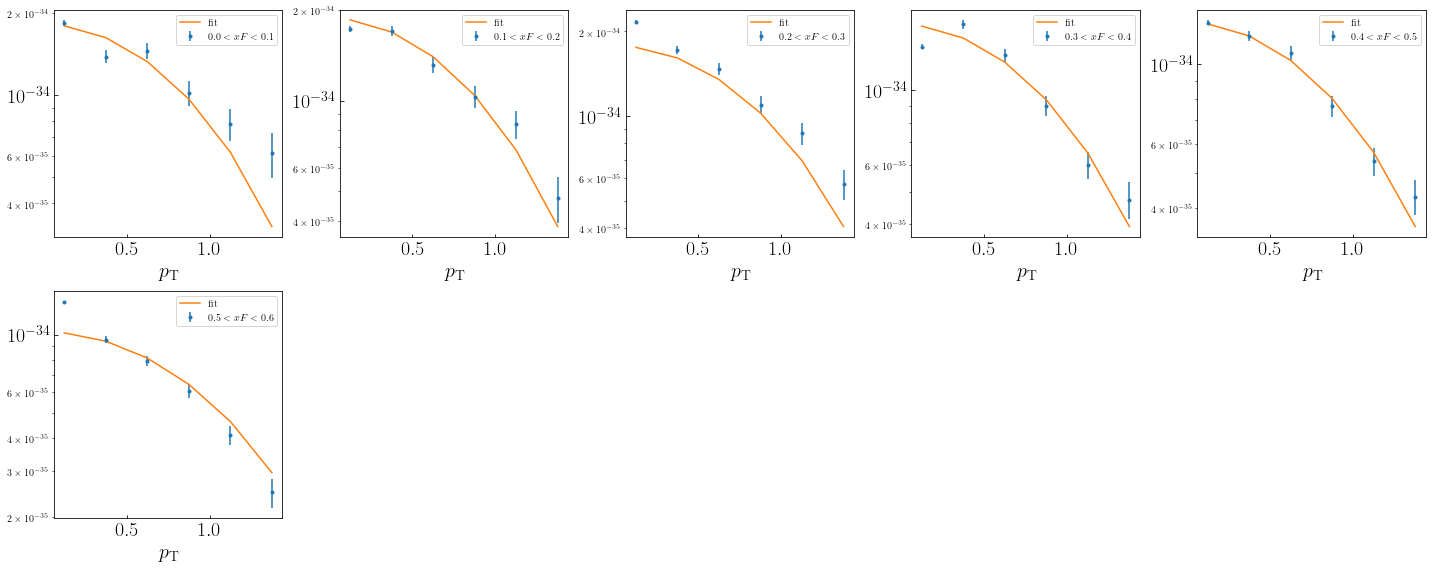

In [36]:
xFbins=[0.05,0.15,0.25,0.35,0.45,0.55]#,0.65,0.75,0.85]

nrows,ncols=2,5
py.figure(figsize=(4*ncols,4*nrows))

tab=pd.DataFrame(maxlike.resman.DYpT_res.tabs[1002])

for i in range(len(xFbins)):
    ax=py.subplot(nrows,ncols,i+1)
    d=tab.query('xFmin<%.2f and xFmax>%.2f and pTmax<0.4*Qmin'%(xFbins[i],xFbins[i]))
    ax.errorbar(d['pT'],d['value']/2/d['pT'],yerr=d['alpha'],fmt='.',label=r'$%.1f<xF<%.1f$'%(d['xFmin'].values[0],d['xFmax'].values[0]))
    ax.plot(d['pT'],d['prediction']/2/d['pT'],label=r'$\rm fit$')
    ax.semilogy()
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_xlabel(r'$p_{\rm T}$',size=20)
    ax.legend()
    
py.tight_layout()
#py.savefig('TMD_gallery/JAM.png')

In [ ]:
#maxlike.run_fit()

In [ ]:
# maxlike.resman=None

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/maxlike.py

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/parman.py

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/resman.py

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/maxlike.py

loading DYpT data sets 12882
12882 has norm uncertainty


### Fixed order term

In [26]:
class FOTERM:
    def __init__(self):
        
        self.CF=4.0/3.0
        self.alpha = conf['aux'].alfa 
        self.alphaS=conf['alphaS'].get_alphaS
        self.Mp = conf['aux'].M 
        self.eU2 = 4./9
        self.eD2 = 1./9
        self.eq2=np.array([0,self.eU2,self.eU2,self.eD2,self.eD2,self.eD2,self.eD2,self.eU2,self.eU2,self.eD2,self.eD2,self.eU2,self.eU2])
        self.iflav=[21,2,-2,1,-1,3,-3,4,-4,5,-5]
        self.flav = ['g','u','ub','d','db','s','sb','c','cb','b','bb']
        self.pdfA=conf['pdf']
        self.pdfB=lhapdf.mkPDF('EPPS16nlo_CT14nlo_Pt195',0)
        
    def get_FO_integrand(self,xa,Q,pT,s,y):
        Q2=Q**2
        tau=Q2/s

        mu=pT/2
#         mu=Q
        if mu<conf['aux'].mc:
            mu=conf['aux'].mc
        mu2=mu**2
        mT=np.sqrt(Q2+pT**2)

        #--rapidity
        if np.abs(y)>np.arccosh((1+tau)/(2*np.sqrt((pT**2+Q**2)/s))):
            return 0

        #--pT
        pTmax=s**0.5/2*(1-tau)
        if pT>pTmax: return 0

        #--momentum fractions
        xT=2*pT/s**0.5
        x1=0.5*(xT**2+4*tau)**0.5*np.exp(y)
        x2=0.5*(xT**2+4*tau)**0.5*np.exp(-y)
        xamin=(x1-tau)/(1-x2)
        if xa>1: xa=1
        xb=(xa*x2-tau)/(xa-x1)
        if xb>1: xb=1

        #--hard factors
        sh=xa*xb*s
        th=-xa*s*x2+Q2
        uh=-xb*s*x1+Q2
        alphaS=self.alphaS(mu2)

        #--qqb->l,lb,g
        HA = alphaS*self.alpha**2*8./27/(Q2*sh**2)*(th/uh+uh/th+2*Q2*sh/(th*uh))
        #--qg -> l,l,q
        HC = -alphaS*self.alpha**2*1./9/(Q2*sh**2)*(th/sh+sh/th+2*Q2*uh/(th*sh))
        HC2= -alphaS*self.alpha**2*1./9/(Q2*sh**2)*(uh/sh+sh/uh+2*Q2*th/(uh*sh))

        #--soft factors
        fA=np.array([self.pdfA.get_xF(xa,mu2,_)/xa for _ in self.flav])
        fB=np.array([self.pdfB.xfxQ2(_,xb,mu2)/xb for _ in self.iflav])
        Nf=conf['alphaS'].get_Nf(mu2)
        iNf=np.zeros(11)
        iNf[1:7]=np.ones(6)
        if Nf>3: iNf[7:9]=np.ones(2)
        if Nf>4: iNf[9:11]=np.ones(2)

        lumA =np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fA[[1,3,5,7,9]]*fB[[2,4,6,8,10]])
        lumA+=np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fA[[2,4,6,8,10]]*fB[[1,3,5,7,9]])

        lumC =np.sum(iNf[[1,2,3,4,5,6,7,8,9,10]]*self.eq2[[1,2,3,4,5,6,7,8,9,10]]*fA[0]*fB[[1,2,3,4,5,6,7,8,9,10]])
        lumC2=np.sum(iNf[[1,2,3,4,5,6,7,8,9,10]]*self.eq2[[1,2,3,4,5,6,7,8,9,10]]*fA[[1,2,3,4,5,6,7,8,9,10]]*fB[0])

        dsigmahat= HA*lumA + HC*lumC + HC2*lumC2
        factor   = xa*xb/(xa-x1)

        return dsigmahat*factor

    def get_xamin(self,Q,pT,s,y):
        Q2=Q**2
        rs=s**0.5
        tau=Q2/s
        xT=2*pT/rs
        if np.abs(y)>np.arccosh((1+tau)/(2*np.sqrt((pT**2+Q**2)/s))): return 1
        x1=0.5*(xT**2+4*tau)**0.5*np.exp(y)
        x2=0.5*(xT**2+4*tau)**0.5*np.exp(-y)
        xamin=(x1-tau)/(1-x2)
        if xamin<0 or xamin>1: xamin=1
        return xamin

    def get_FO_3diff(self,Q,pT,s,y):
        #--This computes dsigma/dQ2dydpT2
        dsig=lambda xa: self.get_FO_integrand(xa,Q,pT,s,y)
        xamin=self.get_xamin(Q,pT,s,y)

        return fixed_quad(np.vectorize(dsig),xamin,1,n=10)[0]

    def get_FO_xF_term(self,pT,xF,s,Qmin,Qmax):
        #--set up the integration here
        units=0.389379e-27
        mT=lambda Q: np.sqrt(Q**2+pT**2)
        y=lambda Q: np.arcsinh(s**0.5*xF/(2*mT(Q)))
        xFjac=lambda Q: s**0.5/(2*mT(Q)*np.cosh(y(Q)))

        dsig=lambda Q: 2*Q*xFjac(Q)*self.get_FO_3diff(Q,pT,s,y(Q))
        sig = fixed_quad(np.vectorize(dsig),Qmin,Qmax,n=10)[0]

        #--if xFobs: returns dsigma/dxFdpT2
        #--else:     returns dsigma/dydpT2
        return sig*units*2*pT
    
    def get_FO_rap_term(self,pT,y,s,Qmin,Qmax):
        #--set up the integration here
        units=0.389379e9
        dsig=lambda Q: 2*Q*self.get_FO_3diff(Q,pT,s,y)
        sig = fixed_quad(np.vectorize(dsig),Qmin,Qmax,n=10)[0]

        #--if xFobs: returns dsigma/dxFdpT2
        #--else:     returns dsigma/dydpT2
        return sig*units     
        

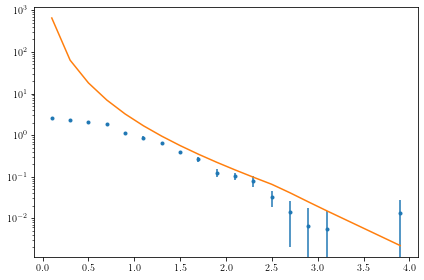

In [27]:
def test():
    tab=pd.read_excel('/work/JAM/barryp/JAM/fitpack2/database/proton_qT/expdata/12882.xlsx')
    
    s=2*conf['aux'].M*tab.E.values
    tab['s']=pd.Series(s,index=tab.index)

    Qmin=tab.Qmin.values
    Qmax=tab.Qmax.values
    Qavg=0.5*(Qmin+Qmax)
    tab['Qmin']=pd.Series(Qmin,index=tab.index)
    tab['Qmax']=pd.Series(Qmax,index=tab.index)
    tab['Q']=pd.Series(Qavg,index=tab.index)

    pTmin,pTmax=tab.pTmin.values,tab.pTmax.values
    pT=0.5*(pTmin+pTmax)
    tab['pT']=pd.Series(pT,index=tab.index)  
    
    fo=FOTERM()
    
    d=tab.query('Qmin<5.5 and Qmax>5.5')
    thy=[fo.get_FO_rap_term(d['pT'].values[i],d['y'].values[i],d['s'].values[i],d['Qmin'].values[i],d['Qmax'].values[i]) for i in range(len(d['pT'].values))]
    ax=py.subplot(111)
    ax.errorbar(d['pT'],d['value'],yerr=d['stat_u'],fmt='.')#,label=r'$%.1f<Q<%.1f$'%(d['Qmin'].values[0],d['Qmax'].values[0]))
    # ax.legend()
    ax.plot(d['pT'],np.array(thy))
    ax.semilogy()
    py.tight_layout()
    
test()

### Asymptotic term

In [28]:
class AYTERM:
    def __init__(self):
        
        self.CF=4.0/3.0
        self.alpha = conf['aux'].alfa 
        self.alphaS=conf['alphaS'].get_alphaS
        self.Mp = conf['aux'].M 
        self.eU2 = 4./9
        self.eD2 = 1./9
        self.eq2=np.array([0,self.eU2,self.eU2,self.eD2,self.eD2,self.eD2,self.eD2,self.eU2,self.eU2,self.eD2,self.eD2,self.eU2,self.eU2])
        self.iflav=[21,2,-2,1,-1,3,-3,4,-4,5,-5]
        self.flav = ['g','u','ub','d','db','s','sb','c','cb','b','bb']
        self.pdfA=conf['pdf']
        self.pdfB=lhapdf.mkPDF('EPPS16nlo_CT14nlo_Pt195',0)
        
    def get_R(self,Q,pT,s,y,za,zb):
        Q2=Q**2
        tau=Q2/s
        
        mu=pT/2
#         mu=Q
#         mu=0.5*(Q**2+pT**2)**0.5
        if mu<conf['aux'].mc:
            mu=conf['aux'].mc
        mu2=mu**2
        mT=np.sqrt(Q2+pT**2)
        
        #--rapidity
        if np.abs(y)>np.arccosh((1+tau)/(2*np.sqrt((pT**2+Q**2)/s))):
            return 0

        #--pT
        pTmax = s**0.5/2*(1-tau)
        if pT>pTmax: return 0

        alphaS=conf['alphaS'].get_alphaS(mu2)

        xa=tau**0.5*np.exp(y)
        xb=tau**0.5*np.exp(-y)

        fA0=np.array([self.pdfA.get_xF(xa,mu2,_)/xa for _ in self.flav])
        fB0=np.array([self.pdfB.xfxQ2(_,xb,mu2)/xb for _ in self.iflav])

        fAZ=np.array([self.pdfA.get_xF(xa/za,mu2,_)/(xa/za) for _ in self.flav])
        fBZ=np.array([self.pdfB.xfxQ2(_,xb/zb,mu2)/(xb/zb) for _ in self.iflav])
        

        # g,u,ub,d,db,s,sb,c,cb,b,bb
        # 0 1  2 3  4 5  6 7  8 9,10
        Nf=conf['alphaS'].get_Nf(mu2)

        iNf=np.zeros(11)
        iNf[1:7]=np.ones(6)
        if Nf>3: iNf[7:9]=np.ones(2)
        if Nf>4: iNf[9:11]=np.ones(2)

        lum0 =np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fA0[[1,3,5,7,9]]*fB0[[2,4,6,8,10]])
        lum0+=np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fA0[[2,4,6,8,10]]*fB0[[1,3,5,7,9]])
        lumZA =np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fAZ[[1,3,5,7,9]]*fB0[[2,4,6,8,10]])
        lumZA+=np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fAZ[[2,4,6,8,10]]*fB0[[1,3,5,7,9]])
        lumZB =np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fA0[[1,3,5,7,9]]*fBZ[[2,4,6,8,10]])
        lumZB+=np.sum(iNf[[1,3,5,7,9]]*self.eq2[[1,3,5,7,9]]*fA0[[2,4,6,8,10]]*fBZ[[1,3,5,7,9]])

        #--qqb
        qprefactor = 8*self.alpha**2*alphaS/(27.0*Q2*s*pT**2)
        Rqqb=0
        #--line 1
        Rqqb+=2*(np.log(Q**2/pT**2)-3.0/2.0)*lum0/(1-xa)/(1-xb)

        #--line 2
        Rqqb+=(1+zb**2)/(1-zb)*(lumZB/zb-lum0)/(1-xa)
        Rqqb+=lum0/(1-xa)/(1-xb)*(1.0/2.0*xb*(2+xb)+2*np.log(1-xb))

        #--line 3
        Rqqb+=(1+za**2)/(1-za)*(lumZA/za-lum0)/(1-xb)
        Rqqb+=lum0/(1-xa)/(1-xb)*(1.0/2.0*xa*(2+xa)+2*np.log(1-xa))
        
        Rqqb*=qprefactor
        
        #--qg
        gprefactor = self.alpha**2*alphaS/(9.0*Q2*s*pT**2)
        lumZBg=np.sum(iNf[[1,2,3,4,5,6,7,8,9,10]]*self.eq2[[1,2,3,4,5,6,7,8,9,10]]*fA0[[1,2,3,4,5,6,7,8,9,10]]*fBZ[[0]])

        Rqg=(zb**2+(1-zb)**2)/zb*lumZBg/(1-xa)
        Rqg*=gprefactor
        
        #--gq
        lumZAg=np.sum(iNf[[1,2,3,4,5,6,7,8,9,10]]*self.eq2[[1,2,3,4,5,6,7,8,9,10]]*fAZ[[0]]*fB0[[1,2,3,4,5,6,7,8,9,10]])

        Rgq=(za**2+(1-za)**2)/za*lumZA/(1-xb)
        Rgq*=gprefactor
        
        return Rqqb+Rqg+Rgq
    
    def get_AY_3diff(self,Q,pT,s,y):
        
        rtau = Q/s**0.5
        xa = rtau*np.exp(y)
        xb = rtau*np.exp(-y)
        dzadzb = lambda za,zb: self.get_R(Q,pT,s,y,za,zb)
        dza = lambda za: fixed_quad(lambda zb: np.vectorize(dzadzb)(za,zb),xb,1,n=5)[0]
        return fixed_quad(np.vectorize(dza),xa,1,n=5)[0]
    
    def get_AY_xF_term(self,pT,xF,s,Qmin,Qmax):
        #--set up the integration here
        units=0.389379e-27
        mT=lambda Q: np.sqrt(Q**2+pT**2)
        y=lambda Q: np.arcsinh(s**0.5*xF/(2*mT(Q)))
        xFjac=lambda Q: s**0.5/(2*mT(Q)*np.cosh(y(Q)))

        dsig=lambda Q: 2*Q*xFjac(Q)*self.get_AY_3diff(Q,pT,s,y(Q))
        sig = fixed_quad(np.vectorize(dsig),Qmin,Qmax,n=10)[0]

        #--if xFobs: returns dsigma/dxFdpT2
        #--else:     returns dsigma/dydpT2
        return sig*units*2*pT
    
    def get_AY_rap_term(self,pT,y,s,Qmin,Qmax):
        #--set up the integration here
        units=0.389379e9
        dsig=lambda Q: 2*Q*self.get_AY_3diff(Q,pT,s,y)
        sig = fixed_quad(np.vectorize(dsig),Qmin,Qmax,n=10)[0]

        #--if xFobs: returns dsigma/dxFdpT2
        #--else:     returns dsigma/dydpT2
        return sig*units
        

        

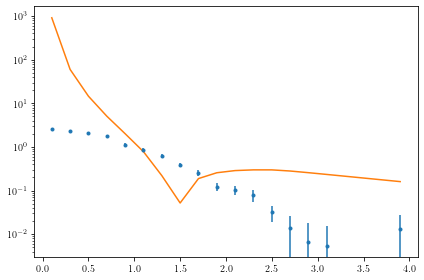

In [29]:
def test():
    tab=pd.read_excel('/work/JAM/barryp/JAM/fitpack2/database/proton_qT/expdata/12882.xlsx')
    
    s=2*conf['aux'].M*tab.E.values
    tab['s']=pd.Series(s,index=tab.index)

    Qmin=tab.Qmin.values
    Qmax=tab.Qmax.values
    Qavg=0.5*(Qmin+Qmax)
    tab['Qmin']=pd.Series(Qmin,index=tab.index)
    tab['Qmax']=pd.Series(Qmax,index=tab.index)
    tab['Q']=pd.Series(Qavg,index=tab.index)

    pTmin,pTmax=tab.pTmin.values,tab.pTmax.values
    pT=0.5*(pTmin+pTmax)
    tab['pT']=pd.Series(pT,index=tab.index)  
    
    ay=AYTERM()
    
    d=tab.query('Qmin<5.5 and Qmax>5.5')
    thy=[ay.get_AY_rap_term(d['pT'].values[i],d['y'].values[i],d['s'].values[i],d['Qmin'].values[i],d['Qmax'].values[i]) for i in range(len(d['pT'].values))]
    ax=py.subplot(111)
    ax.errorbar(d['pT'],d['value'],yerr=d['stat_u'],fmt='.')#,label=r'$%.1f<Q<%.1f$'%(d['Qmin'].values[0],d['Qmax'].values[0]))
    # ax.legend()
    ax.plot(d['pT'],np.array(np.abs(thy)))
    ax.semilogy()
    py.tight_layout()
    
test()

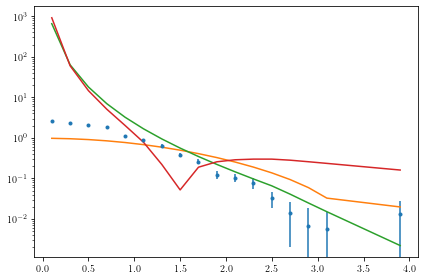

In [30]:
def test():
    tab=pd.read_excel('/work/JAM/barryp/JAM/fitpack2/database/proton_qT/expdata/12882.xlsx')
    
    s=2*conf['aux'].M*tab.E.values
    tab['s']=pd.Series(s,index=tab.index)

    Qmin=tab.Qmin.values
    Qmax=tab.Qmax.values
    Qavg=0.5*(Qmin+Qmax)
    tab['Qmin']=pd.Series(Qmin,index=tab.index)
    tab['Qmax']=pd.Series(Qmax,index=tab.index)
    tab['Q']=pd.Series(Qavg,index=tab.index)

    pTmin,pTmax=tab.pTmin.values,tab.pTmax.values
    pT=0.5*(pTmin+pTmax)
    tab['pT']=pd.Series(pT,index=tab.index)  
    
    w=WTERM()
    fo=FOTERM()
    ay=AYTERM()
    
    d=tab.query('Qmin<5.5 and Qmax>5.5')
    wthy=[w.get_Ed3sigdp3(d['pT'].values[i],d['Qmin'].values[i],d['Qmax'].values[i],d['y'].values[i],d['s'].values[i]) 
             for i in range(len(d['pT'].values))]
    fothy=[fo.get_FO_rap_term(d['pT'].values[i],d['y'].values[i],d['s'].values[i],d['Qmin'].values[i],d['Qmax'].values[i]) for i in range(len(d['pT'].values))]
    aythy=[ay.get_AY_rap_term(d['pT'].values[i],d['y'].values[i],d['s'].values[i],d['Qmin'].values[i],d['Qmax'].values[i]) for i in range(len(d['pT'].values))]
    ax=py.subplot(111)
    ax.errorbar(d['pT'],d['value'],yerr=d['stat_u'],fmt='.')#,label=r'$%.1f<Q<%.1f$'%(d['Qmin'].values[0],d['Qmax'].values[0]))
    ax.plot(d['pT'],np.array(np.abs(wthy)))
    ax.plot(d['pT'],np.array(np.abs(fothy)))
    ax.plot(d['pT'],np.array(np.abs(aythy)))
    ax.semilogy()
    py.tight_layout()
    
test()